In [ ]:
# ⛑️ COLAB SETUP CELL — RUN FIRST
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✅ Running in Google Colab. Installing required packages...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets", "matplotlib", "pandas", "scipy"])
        from google.colab import output
        output.enable_custom_widget_manager()
    except Exception as e:
        print("⚠️ Package install or widget setup failed:", str(e))
else:
    print("🧪 Running locally — skipping Colab setup.")


In [18]:
import ipywidgets as widgets
from IPython.display import display

# Invisible warm-up widget
dummy = widgets.HTML("Loading widget support…")
display(dummy)


HTML(value='Loading widget support…')

# Telescope Section

## Understanding Telescope Parameters
The telescope is the first optical component in the spectroheliograph system. It determines how much light enters and how solar features are projected onto the entrance slit.

### Aperture and Focal Length
The **aperture** defines how much light enters the telescope. The **focal length** determines magnification and resolution.

### Focal Ratio
The focal ratio, denoted as \( $ f_r $ \), is defined as: $ f_r = \frac{F}{D} $

This value impacts the system’s depth of field and brightness.

### Stopped-Down Aperture
If the aperture is reduced using a stop-down mechanism, the **effective focal ratio** is updated dynamically.

### Interactive Inputs
You will be prompted to enter:
- Telescope aperture (mm)
- Focal length (mm)
- Stopped-down aperture (if applicable)

In [19]:
# @title
import ipywidgets as widgets
from IPython.display import HTML, display

# Create interactive widgets
aperture = widgets.FloatText(value=80, description="🔭 Aperture (mm):", style={"description_width":"auto"})
focal_length = widgets.FloatText(value=400, description="📏 Focal Length (mm):", style={"description_width":"auto"})
stopped_down_aperture = widgets.FloatText(description="⏳ Stopped-Down Aperture (mm):", style={"description_width":"auto"})
use_stopped_down = widgets.Checkbox(value=False, description="Use stopped-down aperture?")

# Arrange widgets
ui = widgets.VBox([aperture, focal_length, use_stopped_down, stopped_down_aperture])
display(ui)

# Output widget
output = widgets.Output()
display(output)

# Global shared parameters
telescope_focal_ratio = None
aperture_effective = None
focal_length_mm = None

# Function to compute and store globally
def calculate_focal_ratio(b=None):
    global telescope_focal_ratio, aperture_effective, focal_length_mm

    with output:
        output.clear_output()

        aperture_effective = stopped_down_aperture.value if use_stopped_down.value else aperture.value
        focal_length_mm = focal_length.value

        if aperture_effective > 0:
            telescope_focal_ratio = focal_length_mm / aperture_effective
            print(f"Effective Focal Ratio: f/{telescope_focal_ratio:.2f}")
        else:
            telescope_focal_ratio = None
            print("⚠️ Aperture must be > 0 to calculate focal ratio.")

# Button to trigger manually
calc_button = widgets.Button(description="Calculate Focal Ratio")
calc_button.on_click(calculate_focal_ratio)
display(calc_button)

# Automatically compute once at load
calculate_focal_ratio()


Output()

Button(description='Calculate Focal Ratio', style=ButtonStyle())

# ☀️ Solar Disk Section
## ☀️ Solar Disk Angular Size

The apparent angular diameter of the Sun varies throughout the year due to Earth's elliptical orbit. Below are typical values observed on the **1st of each month**.

Select the solar disk size from the dropdown to use the correct value for calculations.

🌍 **Why does the Solar Disk change?**  
Since Earth's distance from the Sun varies, the Sun appears slightly larger or smaller at different times of the year.

In [20]:
# @title
import ipywidgets as widgets
from IPython.display import display

# Solar disk values by month
solar_disk_values = {
    "Maximum Value": 32.53,  # Highest recorded value
    "January": 32.53,
    "February": 32.47,
    "March": 32.27,
    "April": 32.00,
    "May": 31.73,
    "June": 31.53,
    "July": 31.47,
    "August": 31.53,
    "September": 31.70,
    "October": 31.96,
    "November": 32.23,
    "December": 32.46,
}

# Dropdown widget
solar_disk_dropdown = widgets.Dropdown(
    options=solar_disk_values,
    value=32.53,  # Default value (Max)
    description="☀️ Solar Disk (arcmin):",
    style={"description_width": "auto"}
)

# Output widget for continuous display
selected_value_output = widgets.Output()

# Function to update displayed value when selection changes
def update_selected_value(change):
    with selected_value_output:
        selected_value_output.clear_output()
        print(f"Selected Solar Disk Size: {solar_disk_dropdown.value} arcmin")

# Observe changes in dropdown and update output
solar_disk_dropdown.observe(update_selected_value, names="value")

# Display elements
display(solar_disk_dropdown, selected_value_output)

# Initialize display with current selection
update_selected_value(None)

Dropdown(description='☀️ Solar Disk (arcmin):', options={'Maximum Value': 32.53, 'January': 32.53, 'February':…

Output()

## 📏 Plate Scale: Understanding the Sun's Image

Plate Scale defines how the angular size of the Sun translates into a measurable size at the slit focus. It helps determine **how much the solar image spreads per millimeter** at the focal plane.

Mathematically, it's given by:

$$
S = \frac{\theta \times 60}{D}
$$

Where:
- **\(S\)** = Plate Scale (**arcsec/mm**)
- **\($\theta$\)** = Solar Disk angular size (**arcmin**)  
- **\(D\)** = Solar Disk size at slit focus (**mm**)  

This calculation allows us to understand how the Sun's apparent size is **represented in the instrument**, ensuring accurate scaling for imaging and analysis. For capturing solar features like sunspots or granulation:
- A plate scale of **0.5 to 2 arcsec/mm** is typically good for **high-resolution imaging**.
- For **general observations**, a scale of **5 to 10 arcsec/mm** works well.

Since we are concerned with a **Spectrohelioscope**, **Plate Scale** probably has a different role in our analysis:
- Instead of resolving fine details in a full solar image, we're ensuring that each pixel in the spectral image represents a consistent angular section of the Sun.
- Each pixel corresponds to a portion of the Sun’s disk, and we likely want the entire strip of pixels to fully cover the disk’s diameter without gaps or excessive oversampling.

In [21]:
# @title
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Output widget for results
solar_output = widgets.Output()

# Function to compute all Solar Disk calculations in one click
solar_disk_slit_size = None  # Global variable placeholder
def calculate_all(b):
    global solar_disk_slit_size  # Explicitly declare it as global

    with solar_output:
        solar_output.clear_output()

        # Retrieve values
        solar_disk_arcmin = solar_disk_dropdown.value
        D = stopped_down_aperture.value if use_stopped_down.value else aperture.value
        F = focal_length.value
        focal_ratio = F / D

        # Compute Solar Disk at Slit Focus
        #solar_disk_slit_size = np.tan(np.radians(solar_disk_arcmin / 60)) * F  # Global assignment
        solar_disk_slit_size = np.tan(np.radians(solar_disk_dropdown.value / 60)) * focal_length.value

        # Compute Plate Scale
        plate_scale = (solar_disk_arcmin * 60) / solar_disk_slit_size

        # Output results
        print(f"🌞 Solar Disk at Slit Focus: {solar_disk_slit_size:.3f} mm")
        print(f"📏 Plate Scale: {plate_scale:.3f} arcsec/mm")

# Single button to run calculations
calculate_button = widgets.Button(description="Run Solar Disk Calculations")
calculate_button.layout = widgets.Layout(width="auto")
calculate_button.on_click(calculate_all)

# Display only the button and output (NOT the dropdown again)
display(calculate_button, solar_output)

# Run solar disk calculation automatically once at load
calculate_all(None)

Button(description='Run Solar Disk Calculations', layout=Layout(width='auto'), style=ButtonStyle())

Output()

# 🌞 Spectrograph Design Introduction

A **spectrohelioscope** is a specialized telescope designed to observe the Sun at **specific wavelengths**, revealing dynamic solar features like sunspots, prominences, and chromospheric activity.

## 🔹 How It Works
- Uses a **narrow slit** to isolate a portion of the Sun’s disk.
- Light passes through a **dispersive element (e.g., diffraction grating or prism)** to separate wavelengths.
- A **specific solar wavelength** (e.g., Hydrogen-alpha at **656.3 nm**) is selected for imaging.
- The output is captured as a **strip of pixels**, corresponding to the solar disk's width at the chosen wavelength.

## 📏 Key Considerations for Design
- **Plate Scale** determines how much of the Sun’s angular size is represented **per millimeter** on the imaging plane.
- **Seeing Conditions** impact resolution and image clarity due to atmospheric turbulence.
- **Slit Width & Camera Pixel Alignment** affect spectral resolution and light throughput.
- **Focal Length & Optical Configuration** dictate the magnification and field coverage of the solar image.

## 🔢 Upcoming Calculation: Seeing Effects
To refine the design, we first calculate the **seeing limit** ($\varepsilon$), then present a dropdown selection of seeing factor and assess how atmospheric turbulence affects image sharpness. This ensures optimal resolution for capturing solar details.
### 🌐 Seeing Disk (FWHM) Explanation

#### 📌 **What is the Seeing Disk?**
The **Seeing Disk** represents the spread of light caused by atmospheric turbulence. This effect **blurs fine details**, limiting resolution in solar imaging.

**FWHM (Full Width at Half Maximum)** is a measure of the width of this blur, calculated at the point where intensity drops to half of its peak value.

#### 📏 **How We Calculate It**
We use the equation:

$$
\text{Seeing Disk (FWHM)} = \tan\left(\frac{\varepsilon}{60 \times 60} \times \frac{\pi}{180} \right) \times \text{Focal Length} \times 1000
$$

Where:
- **\( $\varepsilon$ \)** = Seeing factor (arcseconds), influenced by atmospheric conditions  
- **Focal Length** = Telescope's focal length (**millimeters**)  
- **1000** = Converts result to **microns (μm)**  

## 🔹 **Why Does It Matter?**
- **Limits resolution**—a smaller FWHM means sharper images.  
- Guides **camera selection & pixel size** for best performance.  
- Helps determine **adaptive optics or stacking techniques** to improve image quality.  

## 🔭 **Impact on Spectrohelioscope Design**
For a spectrohelioscope, understanding **seeing disk size** ensures that the solar spectral image is properly captured **without excessive blurring**, allowing for accurate **wavelength-dependent observations**.

In [22]:
# @title
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Seeing Factor Dropdown (User selects seeing in arcseconds)
seeing_dropdown = widgets.Dropdown(
    options={
        "Exceptional (0.5 arcsec)": 0.5,
        "Very Good (1 arcsec)": 1,
        "Average (2 arcsec)": 2,
        "Poor (3 arcsec)": 3,
        "Bad (5 arcsec)": 5
    },
    value=2,  # Default: Average seeing
    description="🌐 Seeing Factor (arcsec):",
    layout=widgets.Layout(width="max-content"),
    style={"description_width": "auto"}
)

# Output widget for seeing calculations
seeing_output = widgets.Output()

# Function to calculate Seeing Limit & Disk (FWHM) using empirical r₀
def calculate_seeing(b):
    with seeing_output:
        seeing_output.clear_output()

        # Telescope inputs
        wavelength = 550e-9  # 550nm (visible light)
        aperture_mm = aperture.value  # User-defined aperture (mm)
        aperture_m = aperture_mm / 1000  # Convert mm to meters
        focal_length_mm = focal_length.value  # Focal length in mm

        # Selected seeing factor (arcsec)
        seeing_arcsec = seeing_dropdown.value

        # Calculate Fried's Parameter (r₀) dynamically
        seeing_radians = seeing_arcsec / 206265  # Convert arcseconds to radians
        fried_r0_m = 0.98 * (wavelength / seeing_radians)

        # Traditional Seeing Limit Calculation (ε)
        seeing_limit_classic = (206265 * wavelength) / aperture_m

        # Seeing Limit using newly calculated r₀
        seeing_limit_r0 = (wavelength / fried_r0_m) * 206265  # Convert to arcseconds

        # Calculate Seeing Disk (FWHM) in microns
        seeing_disk_fwhm = np.tan(np.radians(seeing_arcsec / 3600)) * focal_length_mm * 1000

        # Print results
        print(f"Wavelength (λ): {wavelength:.3e} m (for seeing calculations)")
        print(f"Calculated Fried's Parameter (r₀): {fried_r0_m:.3f} m")
        print(f"Seeing Limit from r₀ Before Scaling: {wavelength / fried_r0_m:.3e} radians")
        print(f"Seeing Limit from r₀ After Conversion: {seeing_limit_r0:.3f} arcsec")
        print()
        print("Compare Classic Limit to Seeing Limit to make sure not diffraction limited!")
        print(f"🔭 Classic Seeing Limit (ε): {seeing_limit_classic:.3f} arcsec")
        print(f"🌐 Seeing Limit from Fried's Parameter (ε): {seeing_limit_r0:.3f} arcsec")
        print(f"📏 Seeing Disk FWHM: {seeing_disk_fwhm:.3f} μm (Microns)")

# Button for calculations
seeing_button = widgets.Button(description="Calculate Seeing Effects")
seeing_button.on_click(calculate_seeing)
seeing_button.layout = widgets.Layout(width="auto")

# Display elements
display(seeing_dropdown, seeing_button, seeing_output)

Dropdown(description='🌐 Seeing Factor (arcsec):', index=2, layout=Layout(width='max-content'), options={'Excep…

Button(description='Calculate Seeing Effects', layout=Layout(width='auto'), style=ButtonStyle())

Output()

# 📖 Optimizing Spectrograph Design: Entrance Slit Considerations  
A spectrograph’s **entrance slit** is critical for determining **resolution, throughput, and spatial solar coverage**. The goal is to achieve **high spectral resolution** while ensuring **adequate light collection** and minimizing optical distortions.

**Spatial Slit Coverage** refers to the portion of the solar surface that is captured through the spectrograph’s entrance slit. It determines how much of the Sun’s disk is imaged onto the slit, which directly impacts spectral data collection and resolution.


## 🔬 Key Factors in Slit Optimization  
1️⃣ **Slit Width** → Determines spectral resolution.  
   - **Narrower slits** improve resolution but reduce light intake.  
   - **Wider slits** increase brightness but can reduce spectral purity.  

2️⃣ **Slit Height** → Defines spatial coverage.  
   - Adjusting **height** affects the field of view and efficiency of data collection.  
   - Optimizing height ensures **maximum solar surface coverage** while maintaining spectral accuracy.  

3️⃣ **Focal Length & Solar Image Projection**  
   - The **telescope’s focal length** determines the **magnification at the slit**.  
   - Scaling the **solar image at the slit focus** properly ensures accurate spectral dispersion.  

## 🛠 Mathematical Framework  
Spatial Slit Coverage refers to the angular extent of the solar surface imaged through the spectrograph’s entrance slit. It’s defined by:
$$ \text{Spatial Coverage} = \text{Slit Width} \times \text{Entrance Slit Scale} $$
Where:
- Slit Width is measured in microns (μm) and defines the physical opening.
- Entrance Slit Scale (arcsec/μm) determines the angular mapping of the slit width onto the solar disk.

🛠 Why This Matters
- A larger slit width increases spatial coverage but may reduce spectral resolution.
- A higher entrance slit scale means the slit maps to a larger portion of the solar surface.
- Optimizing both ensures precise solar imaging and spectral analysis.

In [23]:
# @title
import ipywidgets as widgets
from IPython.display import display

# Input for Slit Width (μm)
slit_width = widgets.FloatText(
    value=10.0,  # Default width in microns
    description="Slit Width (μm):",
    style={"description_width": "auto"}
)

# Input for Slit Height (mm)
slit_height = widgets.FloatText(
    value=4.5,  # Default height in millimeters
    description="Slit Height (mm):",
    style={"description_width": "auto"}
)

# Output widget for calculations
slit_output = widgets.Output()

# Function to Calculate Entrance Slit Scale & Spatial Coverage
def calculate_slit_coverage(b):
    with slit_output:
        slit_output.clear_output()

        # Compute Entrance Slit Scale (C14)
        entrance_slit_scale = (focal_length.value * 60) / (solar_disk_slit_size * 1000)

        # Compute Entrance Slit Scale (C14)
        entrance_slit_scale = (solar_disk_dropdown.value * 60) / (solar_disk_slit_size * 1000)

        # Compute Spatial Solar Coverage
        spatial_coverage = slit_width.value * entrance_slit_scale

        # Display Results
        print(f"📏 Slit Width: {slit_width.value:.1f} μm")
        print(f"📐 Slit Height: {slit_height.value:.1f} mm")
        print(f"🔭 Focal Length: {focal_length.value:.1f} mm")
        print(f"☀ Solar Disk Size on Slit: {solar_disk_slit_size:.1f} mm")
        print(f"📊 Entrance Slit Scale: {entrance_slit_scale:.6f} arcsec/μm")
        print(f"🌞 Spatial (Solar Surface) Slit Coverage: {spatial_coverage:.3f} arcsec")

# Button for calculations
slit_button = widgets.Button(description="Calculate Slit Coverage")
slit_button.on_click(calculate_slit_coverage)
slit_button.layout = widgets.Layout(width="auto")

# Display elements
display(slit_width, slit_height, slit_button, slit_output)

FloatText(value=10.0, description='Slit Width (μm):', style=DescriptionStyle(description_width='auto'))

FloatText(value=4.5, description='Slit Height (mm):', style=DescriptionStyle(description_width='auto'))

Button(description='Calculate Slit Coverage', layout=Layout(width='auto'), style=ButtonStyle())

Output()

# 📖 Optimizing Spectrograph Design: Implementation Order  

A spectrograph consists of **multiple interdependent components**, each influencing spectral resolution, light throughput, and image quality. The following implementation order ensures that key design decisions are built logically and systematically.

## 🔬 **Chosen Order for Implementation**
### 1️⃣ Grating Selection (Sets Dispersion & Wavelength Range)  
   - The **grating ruling (lines/mm)** determines spectral resolution.  
   - **Blaze angle** affects efficiency across the wavelength range.  
   - Since the grating directly controls **light dispersion**, it must be chosen first to define spectral characteristics.

### 2️⃣ Collimator Lens (Ensures Parallel Illumination to Grating)  
   - Ensures **incoming light is collimated** before hitting the grating, preventing aberrations.  
   - **Collimator focal length** determines how efficiently light is directed to the grating.  
   - The grating’s performance depends on **proper beam shaping**, making the collimator the next logical step.

### 3️⃣ Wavelength Range Definition (Refines Spectral Coverage)  
   - After selecting the grating and collimator, define the **spectral bandpass**.  
   - Spectral coverage depends on **dispersion and detector sensitivity**.  
   - Optimizing wavelength range ensures the final image captures the correct portion of the spectrum.

### 4️⃣ Camera Objective Lens (Controls Image Formation & Focus)  
   - Determines **how the dispersed spectrum is focused onto the detector**.  
   - The **camera lens focal length** must complement the collimator and grating setup.  
   - Ensuring sharp imaging of the spectral lines is the final step, closing the optical pathway.

---

## 🚀 **Why This Order?**
✔ **Starts with the grating**, since it sets fundamental dispersion properties.  
✔ **Collimator ensures light enters the grating correctly, improving performance.**  
✔ **Wavelength range must be fine-tuned before selecting the final optics.**  
✔ **Ends with the camera, ensuring the captured spectrum is properly resolved.**  

By following this structured order, the spectrograph components **work together efficiently**, maximizing spectral resolution and ensuring **precise data collection**.  


# 📖 Optimizing Spectrograph Grating Selection

The **diffraction grating** is the core dispersive element of the spectrograph, responsible for splitting light into its constituent wavelengths. Choosing the right grating parameters ensures **optimal spectral resolution, throughput, and efficiency**.

---

## 🔬 Key Grating Parameters

### 1️⃣ Grating Lines per mm
- Defines the **dispersion rate** — higher lines/mm increase spectral resolution but reduce wavelength coverage.
- Directly affects how finely wavelengths are separated on the detector.

### 2️⃣ Grating Diffraction Order
- Determines which order of diffracted light is used (usually first order).
- Higher orders **increase resolution** but require more careful wavelength calibration and blaze angle tuning.

### 3️⃣ Grating Physical Dimensions (Height & Width)
- Must be large enough to fully intercept the collimated beam.
- **Minimum size** is governed by:
  - The **projected solar disk size** at the slit.
  - The **collimator focal length** and output beam diameter.
- Undersizing causes **vignetting** and spectral loss.

---

## 📐 Spectrograph Geometry (Reflection Grating Configuration)

This spectrograph uses a **reflection grating**, which both reflects and diffracts the collimated beam. The design follows a **classic folded layout**, where the camera path is typically separated by **~34°** from the collimator axis.

![Reflection Grating Diagram](https://github.com/mdroberts1243/spectrograph-notebook/blob/main/Reflection_Grating_Angles.png?raw=1)

### 📏 Grating Equation

The angular dispersion follows the **grating equation**:

$$
m \lambda = d (\sin \theta_i + \sin \theta_d)
$$

Where:

- $m$ = diffraction order  
- $\lambda$ = wavelength  
- $d$ = groove spacing (e.g., 1/1200 mm for 1200 lines/mm)  
- $\theta_i$ = angle of incidence  
- $\theta_d$ = angle of diffraction

> ✅ For a first-order spectrum ($m = 1$), both resolution and efficiency depend on your choice of $\theta_i$, $\theta_d$, and the blaze angle.

### 🧩 Geometry Notes

- The **34° angular separation** between the incident and diffracted paths corresponds to:

  $$
  \theta_d - \theta_i \approx 34^\circ
  $$

- This separation:
  - Ensures beam paths do not overlap.
  - Simplifies mechanical packaging.
  - Aligns the spectrum toward the camera without requiring excessive folding.

- **Blaze angle** ($\theta_B$) tuning maximizes efficiency near a target wavelength (e.g., 656.3 nm for H-alpha).

> 📌 Mount the grating so that the **beam is centered near the blaze angle** at your design wavelength and the mechanical footprint remains compact.

---

## ⚙️ Interdependencies with Other Spectrograph Components

✔ **Slit Width & Height** — Defines the light beam’s angular size and spectral footprint  
✔ **Collimator Lens** — Produces the uniform parallel beam that illuminates the grating  
✔ **Camera Objective & Detector** — Receives the dispersed spectrum and focuses it onto the sensor

---

## 🚀 Summary: Integrated Performance Considerations

✔ The **solar image** projected onto the slit defines how much light reaches the grating.  
✔ The **collimator focal length and aperture** control beam divergence and grating illumination.  
✔ The **grating’s groove density, blaze angle, and angular placement** determine spectral resolution and efficiency.  
✔ The **camera system** must match the diffraction angle and scale the spectrum onto the detector with sufficient sharpness.

> 🧠 Properly aligning grating selection with optical geometry ensures that **your spectrograph achieves both high resolution and high efficiency** at your wavelength of interest.



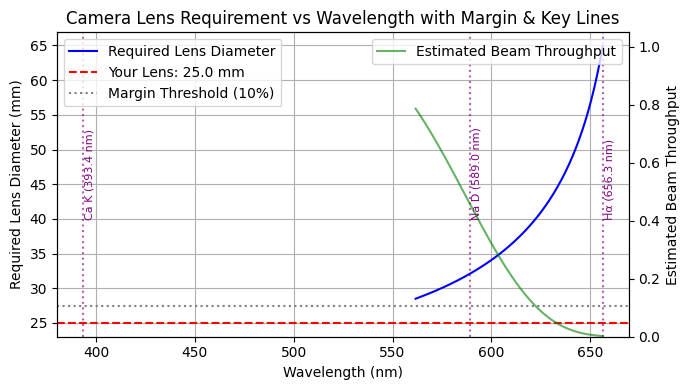

In [24]:
# @title
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown
from scipy.optimize import root_scalar

# Global placeholders
grating_result_theta_i = None
grating_result_theta_d = None
theta_d_lambda_min = None
theta_d_lambda_max = None

# Output widget
grating_output = widgets.Output()

# --- Widgets ---
groove_density_widget = widgets.FloatText(
    value=2400, description="Grating (lines/mm):", style={"description_width": "auto"}
)

diffraction_order_widget = widgets.BoundedIntText(
    value=1, min=1, max=5, description="Diffraction Order m:", style={"description_width": "auto"}
)

beam_angle_widget = widgets.FloatText(
    value=34.0, description="Collimator–Camera Angle (°):", style={"description_width": "auto"}
)

solar_lines = {
    "Hα (656.3 nm)": 656.3,
    "Ca K (393.4 nm)": 393.4,
    "Ca H (396.8 nm)": 396.8,
    "Na D (589.0 nm)": 589.0,
    "Hβ (486.1 nm)": 486.1,
    "Manual Entry": None
}

reference_selector = widgets.Dropdown(
    options=list(solar_lines.keys()),
    value="Hα (656.3 nm)",
    description="Reference Line:", style={"description_width": "auto"}
)

reference_wavelength_widget = widgets.FloatText(
    value=656.3, description="Wavelength (nm):", style={"description_width": "auto"}
)

def update_reference_visibility(change):
    if change["new"] == "Manual Entry":
        reference_wavelength_widget.layout.display = "block"
    else:
        reference_wavelength_widget.value = solar_lines[change["new"]]
        reference_wavelength_widget.layout.display = "none"

reference_selector.observe(update_reference_visibility, names="value")
update_reference_visibility({"new": reference_selector.value})

# --- Grating Solver ---
def solve_grating_geometry(wavelength_nm, m, delta_deg, groove_spacing_mm):
    global grating_result_theta_i, grating_result_theta_d
    wl_mm = wavelength_nm * 1e-6
    delta_rad = np.radians(delta_deg)

    def grating_eq(theta_i_rad):
        return m * wl_mm - groove_spacing_mm * (
            np.sin(theta_i_rad) + np.sin(theta_i_rad + delta_rad)
        )

    theta_min = np.radians(5)
    theta_max = np.radians(89)
    f_min = grating_eq(theta_min)
    f_max = grating_eq(theta_max)

    if f_min * f_max > 0:
        return {
            "θᵢ (deg)": "Invalid",
            "θ_d (deg)": "Invalid",
            "Grating Tilt (deg)": "Invalid"
        }

    try:
        result = root_scalar(grating_eq, bracket=[theta_min, theta_max], method='brentq')
        if result.converged:
            theta_i = np.degrees(result.root)
            grating_result_theta_i = theta_i
            theta_d = theta_i + delta_deg
            grating_result_theta_d = theta_d
            tilt = 90 - theta_i
            return {
                "θᵢ (deg)": round(theta_i, 2),
                "θ_d (deg)": round(theta_d, 2),
                "Grating Tilt (deg)": round(tilt, 2)
            }
        else:
            raise RuntimeError("Root solver did not converge")
    except Exception:
        return {
            "θᵢ (deg)": "Invalid",
            "θ_d (deg)": "Invalid",
            "Grating Tilt (deg)": "Invalid"
        }

def grating_wavelength_bounds(groove_density, beam_angle_deg, order=1):
    """
    Returns (λ_min, λ_max) in nanometers for given groove density and geometry.
    """
    d = 1 / groove_density  # mm
    delta = np.radians(beam_angle_deg)

    # Sweep θᵢ to find extreme values
    theta_vals = np.radians(np.linspace(0.01, 89.9, 1000))
    sin_sum = np.sin(theta_vals) + np.sin(theta_vals + delta)

    max_lambda_mm = d * np.max(sin_sum) / order
    min_lambda_mm = d * np.min(sin_sum) / order

    return round(min_lambda_mm * 1e6, 2), round(max_lambda_mm * 1e6, 2)  # nm


# --- Update Function ---
def update_grating_output(change=None):
    with grating_output:
        grating_output.clear_output()

        groove_density = groove_density_widget.value
        groove_spacing = 1 / (groove_density)  # mm
        m = diffraction_order_widget.value
        delta = beam_angle_widget.value

        lines = {
            "Hα": 656.3,
            "Hβ": 486.1,
            "Ca K": 393.4,
            "Ca H": 396.8,
            "Na D": 589.0
        }

        data = []
        for label, wl in lines.items():
            result = solve_grating_geometry(wl, m, delta, groove_spacing)
            data.append((label, wl, result["θᵢ (deg)"], result["θ_d (deg)"], result["Grating Tilt (deg)"]))

        # Extract valid diffraction angles for the defined solar lines
        theta_ds = [entry[3] for entry in data if isinstance(entry[3], (int, float))]

        # Set global min/max for use in downstream blocks
        global theta_d_lambda_min, theta_d_lambda_max
        if theta_ds:
            theta_d_lambda_min = min(theta_ds)
            theta_d_lambda_max = max(theta_ds)

        df = pd.DataFrame(data, columns=["Line", "Wavelength (nm)", "θᵢ (deg)", "θ_d (deg)", "Grating Tilt (deg)"])
        display(Markdown("### 📏 Grating Angle Calculations for Solar Lines"))
        display(df)

        # Reference wavelength summary
        selected_wl = reference_wavelength_widget.value
        result = solve_grating_geometry(selected_wl, m, delta, groove_spacing)
        display(Markdown(f"### 🔧 Reference Line: **{selected_wl} nm**"))
        display(pd.DataFrame([result]))

        # --- Print grating limits ---
        lambda_min, lambda_max = grating_wavelength_bounds(groove_density, delta, m)
        display(Markdown(f"### 📡 Grating Wavelength Bounds"))
        display(Markdown(f"**Minimum λ:** {lambda_min} nm  **Maximum λ:** {lambda_max} nm"))

# --- Trigger on widget change ---
for w in [groove_density_widget, diffraction_order_widget, beam_angle_widget,
          reference_selector, reference_wavelength_widget]:
    w.observe(update_grating_output, names="value")

# --- Display all widgets ---
display(widgets.VBox([
    groove_density_widget,
    diffraction_order_widget,
    beam_angle_widget,
    reference_selector,
    reference_wavelength_widget,
    grating_output
]))

update_grating_output()

try:
    # type: ignore[name-defined]
    update_camera_values()
except:
    pass  # camera block may not be loaded yet


# 📖 Optimizing Spectrograph Collimator Lens Selection

The **collimator lens** ensures that light emerging from the entrance slit becomes a **parallel beam** before reaching the diffraction grating. Proper collimation is essential for:

- **Accurate spectral dispersion**  
- **Minimal optical aberrations**  
- **High spectral resolution**

Careful selection of collimator parameters ensures that the beam matches the optical requirements of the grating and downstream optics.

---

## 🔬 Key Collimator Parameters

### 1️⃣ Focal Length (User Input)
- Defines how the divergent beam from the slit is shaped into a parallel beam.
- Determines beam size on the grating and camera focal plane.
- Affects physical distances between slit, grating, and camera lens.
- Typically selected to balance **resolution**, **system size**, and **optical throughput**.

### 2️⃣ Minimum Collimator Diameter (Calculated)

To prevent vignetting and preserve full spectral data:

$$
\text{Minimum Diameter} = \left( \frac{\text{Telescope Aperture} \times \text{Collimator Focal Length}}{\text{Telescope Focal Length}} \right) + \text{Slit Height}
$$

- The first term ensures the beam cone from the telescope is fully captured.
- The slit height term ensures full vertical coverage of the projected solar disk.

> **Note**: Always choose the larger of the calculated minimum or suggested diameter (matching telescope focal ratio).

### 3️⃣ Effective Focal Ratio Matching
- A well-matched focal ratio between the telescope and the collimator ensures the beam remains properly shaped.
- Mismatch leads to beam clipping (if too small) or light overfilling the optics (if too large), degrading resolution or wasting aperture.

---

## 🧠 Diffraction-Limited Angular Resolution

The collimator lens acts as an aperture, imposing a **diffraction limit** on angular resolution. This limit is governed by the **Rayleigh criterion**:

$$
\theta = \frac{1.22 \cdot \lambda}{D}
$$

Where:

- \( $\theta$ \): angular resolution in **radians**  
- \( $\lambda$ \): wavelength of light (e.g., 656.3 nm for Hydrogen Alpha)  
- \( D \): collimator lens diameter

To convert to arcseconds:

$$
\text{Resolution (arcsec)} = \theta \cdot 206265
$$

> ✅ This ensures that your collimator lens is not the **limiting factor** in resolving fine angular detail.  
> ❗ This is **not** the same as **spectral FWHM**, which depends on slit width, dispersion, and camera optics.

---

## 📐 Collimator Focal Length & Physical Layout

The collimator’s **focal length** sets the mechanical spacing and optical footprint of the spectrograph:

- **Slit to Collimator**: Slit must lie at the **collimator’s focal plane**.
- **Collimator to Grating**: The beam is now collimated (parallel); grating placement allows full beam coverage.
- **Grating to Camera Lens**: Roughly equals the camera lens focal length, depending on desired spectral scaling.

Correct spacing ensures:

- Full spectral dispersion across the grating
- Sharp focus of spectral lines on the detector
- Optimal light throughput and minimal optical aberrations

---

All downstream performance depends on correct **collimator selection and positioning**.

---

## ✅ Summary Guidance

Choose a **collimator lens** that:

- Has a **focal length** suited to your grating and layout
- Has a **diameter** large enough to capture the beam from your telescope and slit
- Matches or slightly exceeds the **telescope focal ratio**
- Ensures **diffraction-limited resolution** better than your slit or atmospheric seeing

This ensures a well-aligned, high-resolution spectrograph with minimal distortion and optimal throughput.


FloatText(value=80.0, description='Collimator Focal Length (mm):', style=DescriptionStyle(description_width='a…

FloatText(value=25.0, description='Collimator Diameter (mm):', style=DescriptionStyle(description_width='auto'…

Output()

Collimator diameter: 25.0


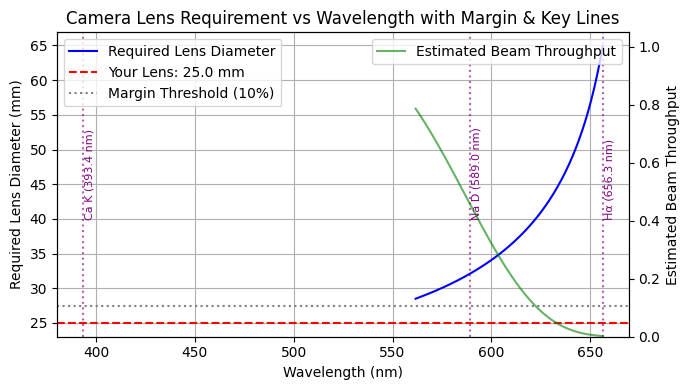

In [25]:
# @title
import ipywidgets as widgets
from IPython.display import display, Markdown

global collimator_diameter

# Output widget for displaying calculations
collimator_output = widgets.Output()

# Function to update collimator calculations
def update_collimator_values(change=None):
    global solar_disk_slit_size, slit_height  # Reference pre-defined variables
    global collimator_diameter

    with collimator_output:
        collimator_output.clear_output()

        # Ensure telescope focal length is available
        telescope_focal_length = focal_length.value  # Directly reference user input

        # Get collimator focal length from user input
        collimator_focal_length = collimator_focal_length_widget.value

        # Get collimator lens diameter from user input
        collimator_diameter = collimator_diameter_widget.value

        # Select correct telescope aperture (Full or Stopped-Down)
        telescope_diameter = stopped_down_aperture.value if use_stopped_down.value else aperture.value

        # Compute minimum collimator diameter
        minimum_diameter = (telescope_diameter * collimator_focal_length / telescope_focal_length) + \
                           (solar_disk_slit_size if solar_disk_slit_size < slit_height.value else slit_height.value)

        # Compute slit-to-collimator distance
        slit_to_collimator_distance = collimator_focal_length

        # Compute suggested diameter to match telescope focal ratio
        collimator_suggested_diameter = collimator_focal_length / telescope_focal_ratio

        # Compute FWHM for Hydrogen Alpha (656.3 nm)
        wavelength = 656.3e-6  # Convert nm to mm
        fwhm_resolution = (1.22 * wavelength) / collimator_diameter
        fwhm_arcsec = fwhm_resolution * 206265  # Convert radians to arcseconds

        collimator_diameter = collimator_diameter_widget.value

        # Display calculated values
        print(f"📏 Minimum Collimator Diameter: {minimum_diameter:.2f} mm")
        print(f"📏 Suggested Collimator Diameter: {collimator_suggested_diameter:.2f} mm")
        print(f"📏 Slit-to-Collimator Distance: {slit_to_collimator_distance:.2f} mm")
        print("NOTE: Choose larger of the two diameters for best performance.")

        display(Markdown("🔬 **Diffraction-Limited Angular Resolution (Hydrogen Alpha, 656.3 nm)**"))
        print(f"✅ Angular Resolution: {fwhm_resolution:.6f} radians")
        print(f"✅ Equivalent in Arcseconds: {fwhm_arcsec:.2f} arcsec")

# Collimator focal length input widget
collimator_focal_length_widget = widgets.FloatText(
    value=80.0, description="Collimator Focal Length (mm):", style={"description_width": "auto"}
)

# Collimator diameter input widget
collimator_diameter_widget = widgets.FloatText(
    value=25.0, description="Collimator Diameter (mm):", style={"description_width": "auto"}
)

# Attach update function to widget changes
collimator_focal_length_widget.observe(update_collimator_values, names="value")
collimator_diameter_widget.observe(update_collimator_values, names="value")

# Display input widgets and calculation output
display(collimator_focal_length_widget, collimator_diameter_widget, collimator_output)

# Perform initial calculation (if necessary parameters are already set)
update_collimator_values()
print("Collimator diameter:", collimator_diameter)

try:
    # type: ignore[name-defined]
    update_camera_values()
except:
    pass


# 📸 Camera Objective Lens Sizing

The **camera objective lens** focuses the dispersed spectrum onto the detector. To avoid spectral clipping and vignetting, it must be sized to fully capture the **diffracted beam** across the desired wavelength range.

🔬 **Lens diameter limits spectrum coverage**: To avoid wavelength clipping, ensure your lens is wide enough to pass rays diffracted at the highest θ_d.

### 🧮 Key Parameters

- **Focal Length** — determines where the detector must be placed.
- **Required Diameter** — depends on grating angles and collimated beam.
- **Spectrum Width** — defines how much physical space is needed on the detector.

Use the values from the grating and collimator sections to compute safe dimensions.


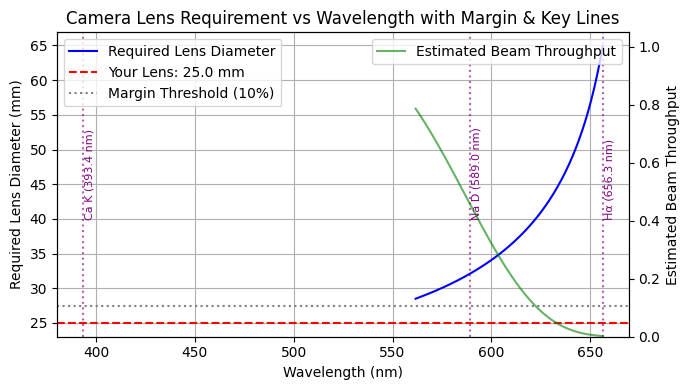

In [26]:
# @title
import ipywidgets as widgets
from IPython.display import display, Markdown
import numpy as np

# Output widget
camera_output = widgets.Output()

# Camera input widgets
camera_focal_length_widget = widgets.FloatText(
    value=125.0, description="Camera Focal Length (mm):", style={"description_width": "auto"}
)

camera_actual_diameter_widget = widgets.FloatText(
    value=25.0, description="Camera Lens Diameter (mm):", style={"description_width": "auto"}
)

# Plot Camera spectrum coverage
def plot_camera_spectrum_coverage(
    collimator_diameter,
    grating_result_theta_i,
    theta_d_lambda_min,
    theta_d_lambda_max,
    groove_density,
    D_camera,
    m=1,
    margin_factor=1.1
):
    import matplotlib.pyplot as plt
    import numpy as np

    d = 1 / groove_density  # mm per groove
    theta_d_range_deg = np.linspace(theta_d_lambda_min, theta_d_lambda_max, 300)
    theta_i_rad = np.radians(grating_result_theta_i)
    theta_d_range_rad = np.radians(theta_d_range_deg)

    # Compute λ for each θ_d
    lambda_range_mm = d * (np.sin(theta_i_rad) + np.sin(theta_d_range_rad)) / m
    lambda_range_nm = lambda_range_mm * 1e6

    # Required lens diameter for each wavelength
    required_diameters = collimator_diameter * (np.cos(theta_i_rad) / np.cos(theta_d_range_rad))

    # Cutoff for lens with margin
    cutoff_index_margin = np.argmax(required_diameters > D_camera * margin_factor)
    lambda_cutoff_margin_nm = lambda_range_nm[cutoff_index_margin] if cutoff_index_margin != 0 else None

    # Gaussian falloff approximation for throughput
    normalized_aperture_ratio = D_camera / required_diameters
    gaussian_throughput = np.clip(np.exp(-((1 - normalized_aperture_ratio) * 4) ** 2), 0, 1)

    important_lines = {
        "Hα (656.3 nm)": 656.3,
        "Na D (589.0 nm)": 589.0,
        "Ca K (393.4 nm)": 393.4
    }

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(7, 4))

    ax1.plot(lambda_range_nm, required_diameters, label="Required Lens Diameter", color='blue')
    ax1.axhline(D_camera, color='red', linestyle='--', label=f"Your Lens: {D_camera:.1f} mm")
    ax1.axhline(D_camera * margin_factor, color='gray', linestyle=':', label="Margin Threshold (10%)")

    for label, wl in important_lines.items():
        ax1.axvline(wl, color='purple', linestyle=':', alpha=0.6)
        ax1.text(wl + 1, ax1.get_ylim()[1]*0.6, label, rotation=90, color='purple', fontsize=8)

    if lambda_cutoff_margin_nm:
        ax1.axvline(lambda_cutoff_margin_nm, color='orange', linestyle='--',
                    label=f"λ Cutoff w/ Margin: {lambda_cutoff_margin_nm:.1f} nm")

    ax1.set_xlabel("Wavelength (nm)")
    ax1.set_ylabel("Required Lens Diameter (mm)")
    ax1.set_title("Camera Lens Requirement vs Wavelength with Margin & Key Lines")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Right y-axis: beam throughput estimate
    ax2 = ax1.twinx()
    ax2.plot(lambda_range_nm, gaussian_throughput, color='green', linestyle='-', alpha=0.6,
             label="Estimated Beam Throughput")
    ax2.set_ylabel("Estimated Beam Throughput")
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# Update function
def update_camera_values(change=None):
    global collimator_diameter, grating_result_theta_i, grating_result_theta_d, theta_d_lambda_min, theta_d_lambda_max

    with camera_output:
        camera_output.clear_output()

        # Get user inputs
        f_camera = camera_focal_length_widget.value
        D_camera = camera_actual_diameter_widget.value

        # Validate required global inputs
        if None in [collimator_diameter, grating_result_theta_i, grating_result_theta_d]:
            print("⚠️ Required values not yet defined (collimator or grating geometry missing).")
            return

        try:
            theta_i = np.radians(grating_result_theta_i)
            theta_d = np.radians(grating_result_theta_d)

            # Required lens diameter to capture current beam angle
            required_diameter = collimator_diameter * (np.cos(theta_i) / np.cos(theta_d))

            print(f"📏 Required Camera Lens Diameter: {required_diameter:.2f} mm")
            print(f"📏 User-Specified Lens Diameter: {D_camera:.2f} mm")

            if D_camera < required_diameter:
                print("⚠️ Camera lens may vignette the beam — increase diameter or reduce angles.")
            else:
                print("✅ Camera lens is large enough to avoid vignetting.")

            # Spectrum width on focal plane
            if theta_d_lambda_min is not None and theta_d_lambda_max is not None:
                delta_theta_d = np.radians(theta_d_lambda_max - theta_d_lambda_min)
                spectrum_width = f_camera * delta_theta_d
                print(f"📐 Estimated Spectrum Width on Detector: {spectrum_width:.2f} mm")
            else:
                print("ℹ️ Spectrum width not computed (θ_d range missing).")

            # --- Beam diameter for full spectrum ---
            try:
                theta_d_max = np.radians(theta_d_lambda_max)
                required_full_spectrum_diameter = collimator_diameter * (np.cos(theta_i) / np.cos(theta_d_max))
                print(f"📏 Required Diameter for Full Spectrum: {required_full_spectrum_diameter:.2f} mm")

                if D_camera < required_full_spectrum_diameter:
                    print("⚠️ Lens may clip spectral endpoints — computing max wavelength captured...")

                    cos_theta_d_cutoff = (collimator_diameter * np.cos(theta_i)) / D_camera
                    if cos_theta_d_cutoff < 1.0:
                        theta_d_cutoff = np.arccos(cos_theta_d_cutoff)

                        groove_density = groove_density_widget.value
                        d = 1 / groove_density  # mm
                        m = diffraction_order_widget.value

                        lambda_cutoff_mm = d * (np.sin(theta_i) + np.sin(theta_d_cutoff)) / m
                        lambda_cutoff_nm = lambda_cutoff_mm * 1e6

                        print(f"⛔ Lens may only pass up to ~{lambda_cutoff_nm:.1f} nm.")
                    else:
                        print("⚠️ Lens is too small to catch any diffracted beam at θ_d_max.")
                else:
                    print("✅ Lens can capture the entire wavelength range.")

            except:
                print("⚠️ Could not determine full spectral capture limits.")

        except Exception as e:
            print("❌ Unexpected error during calculation.")
            print(str(e))

    # Useful visual plot of performance
    try:
        plot_camera_spectrum_coverage(
            collimator_diameter=collimator_diameter,
            grating_result_theta_i=grating_result_theta_i,
            theta_d_lambda_min=theta_d_lambda_min,
            theta_d_lambda_max=theta_d_lambda_max,
            groove_density=groove_density_widget.value,
            D_camera=D_camera
        )
    except Exception as e:
        print("⚠️ Could not generate coverage plot.")
        print(str(e))

# Attach change observers
camera_focal_length_widget.observe(update_camera_values, names="value")
camera_actual_diameter_widget.observe(update_camera_values, names="value")

# Display widgets
display(widgets.VBox([
    camera_focal_length_widget,
    camera_actual_diameter_widget,
    camera_output
]))

# Run once on load
update_camera_values()


### Interpreting the Lens Coverage vs Wavelength Plot

This plot shows how your **camera lens diameter** affects which parts of the spectrum your spectrograph can capture.

#### Key Features:

- **Blue Curve** — the minimum lens diameter required to capture light diffracted at each wavelength.
- **Red Dashed Line** — your actual lens diameter.
- **Gray Dotted Line** — a 10% margin above your lens size (useful for safety or design tolerance).
- **Purple Lines** — key solar lines like **Ca K**, **Na D**, and **Hα**.
- **Orange Line** — the **cutoff wavelength**, above which your lens may clip light if it's too small.
- **Green Curve** — an estimated **beam throughput** that models how much light makes it through the lens even near its edges.

#### How to Use This:

- If the **blue curve is below the red line**, that wavelength is **fully captured**.
- If the **blue curve rises above**, your lens may **vignette** (clip) the outer beam — but the green curve shows that **partial transmission** still occurs.
- If you're working near a **cutoff wavelength**, consider using a **larger lens** to prevent signal loss.

> 💡 **Example**: If you observe Hα at 656.3 nm, and the blue curve at that wavelength is still below your red line, you're in good shape!

---

